# S2 Statistics for Data Science - Coursework Submission
### Steven Dillmann

**MPhil Data Intensive Science | University of Cambridge**

28th March 2024

[sd2022@cam.ac.uk](sd2022@cam.ac.uk)

This notebook was written by Steven Dillmann as part of the coursework submission for the *Statistics for Data Science* module in the MPhil in Data Intensive Science at the University of Cambridge. The coursework assignment can be found here: [Statistics for Data Science - Coursework Assignment](../lighthouse.pdf). The associated report can be found here: [Statistics for Data Science - Coursework Report](../report/s2_sd2022_report.pdf).

## Set-Up

### Installations

In [17]:
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install pandas
!pip install statsmodels
!pip install emcee
!pip install seaborn
!pip install zeus-mcmc
!pip install arviz

### Imports and Settings

In [18]:
# Import required libraries
import numpy as np
from scipy.stats import cauchy, uniform, multivariate_normal, lognorm, loguniform
import pandas as pd
import seaborn as sns
import emcee
import arviz as az
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Set up matplotlib style and colours
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.patches as patches
plt.style.use('sd2022.mplstyle')
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.family'] = 'Gill Sans'
sd2022_blue = '#3772ff'
sd2022_red = '#FF033E'
sd2022_green = '#05a45c'
sd2022_purple = '#994d9e' # DIS logo colour
sd2022_orange = '#ff8243'
sd2022_pink = '#df37d6'
sd2022_turq = '#30d5c8'
sd2022_gold = '#cfbd62' 
sd2022_silver = '#C0C0C0'
sd2022_bronze =  '#b08d57' # '#CD7F32'
color_dict = {'red':   [(0.0, 1.0, 1.0), (1.0, 1.0, 1.0)],
              'green': [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)],
              'blue':  [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)]}
cmap_orange = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',sd2022_orange], N=256)
cmap_purple = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',sd2022_purple], N=256)
cmap_pink = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',sd2022_pink], N=256)
cmap_turq = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',sd2022_turq], N=256)

# Set up some random seeds
seed_dob = 260699
seed_fave_song = 505
seed_football_number = 11
seed_love = 230711

### Load Data

In [19]:
# === Load Data ===============================================================

# Set file path
file_path = '../data/lighthouse_flash_data.txt'

# Load data
data = np.loadtxt(file_path, delimiter=' ')
x_data = data[:, 0] # locations at which the flashes were observed
i_data = data[:, 1] # intensity of the observed flashes

## Original Lighthouse Problem - Part (v)

### Bayes' Theorem 

In [20]:
# === Define Log-Likelihood, Log-Prior and Log-Posterior Functions ============

# Log-likelihood function for a set of flash locations
def log_likelihood_cauchy(data, alpha, beta):
    """
    Calculate the log-likelihood of observing a set of flashes at locations 
    data given the parameters alpha and beta.
    """
    # Log-likelihoods for the locations of single flashes
    log_likelihoods = cauchy.logpdf(data, loc=alpha, scale=beta)

    # Log-likelihood for a set of flash locations (product of log-likelihoods)
    log_likelihood = np.sum(log_likelihoods)

    return log_likelihood

# Uniform prior in log
def log_prior_uniform(param, range):
    """
    Calculate the prior probability of a parameter given a uniform prior (in 
    log).
    """
    return uniform.logpdf(param, loc=range[0], scale=range[1]-range[0])

# Log posterior probability
def log_posterior(data, alpha, beta, alpha_range, beta_range):
    """
    Calculate the unnormalised log posterior probability of the parameters 
    alpha and beta given the observed data with Bayes theorem.
    """
    # Calculate the log likelihood of the observed data given alpha and beta
    log_likelihood = log_likelihood_cauchy(data, alpha, beta)
    
    # Calculate the log prior probabilities of alpha and beta
    log_prior_alpha = log_prior_uniform(alpha, alpha_range)
    log_prior_beta = log_prior_uniform(beta, beta_range)

    # Calculate the log posterior of alpha and beta given the data (Bayes rule)
    log_posterior = log_likelihood + log_prior_alpha + log_prior_beta

    return log_posterior

### Metropolis-Hastings MCMC Sampling

In [21]:
# === Implement the Metropolis-Hastings algorithm =============================

def metropolis_hastings(data, initial_params, alpha_range, beta_range, n_steps, 
                        step_size, seed = None):
    """
    Implement the Metropolis-Hastings algorithm to sample from the posterior
    distribution of the parameters alpha and beta given the observed data.

    Parameters
    ----------
    data : array
        The observed data.
    initial_params : array
        The initial values of the parameters alpha and beta.
    alpha_range : array
        The range of the uniform prior for alpha.
    beta_range : array
        The range of the uniform prior for beta.
    n_steps : int
        The number of steps to run the algorithm for.
    step_size : float
        The standard deviation of the proposal distribution.
    seed : int
        The random seed to use.

    Returns
    -------
    chain : array
        The chain of samples from the posterior distribution.
    acceptance_rate : float
        The acceptance rate of the algorithm.
    """
    # Set random seed
    np.random.seed(seed)
    # Initialise the chain
    chain = np.zeros((n_steps, len(initial_params)))
    chain[0] = initial_params
    n_accepted = 0

    # Loop through the number of steps
    for i in range(n_steps-1):
        # Current state
        current_state = chain[i]
        # Proposal distribution
        proposal = multivariate_normal(mean=chain[i], cov=np.eye(2)*(step_size**2))
        # Proposed state
        proposed_state = proposal.rvs()
        # Log posterior of the current state
        log_posterior_current = log_posterior(data, current_state[0], current_state[1], 
                                              alpha_range, beta_range)
        # Log posterior of the proposed state
        log_posterior_proposed = log_posterior(data, proposed_state[0], 
                                               proposed_state[1], alpha_range, 
                                               beta_range)
        # Acceptance ratio
        log_acceptance_ratio = log_posterior_proposed - log_posterior_current
        # Accept or reject the proposed state
        if np.log(np.random.uniform()) < log_acceptance_ratio:
            chain[i+1] = proposed_state
            n_accepted += 1
        else:
            chain[i+1] = current_state

    # Acceptance rate
    acceptance_rate = n_accepted / n_steps

    return chain, acceptance_rate

# === Run the Metropolis-Hastings algorithm ===================================

# Set the initial parameters
alpha_init = 0
beta_init = 4
initial_params = np.array([alpha_init, beta_init])

# Set the ranges for the uniform priors
alpha_range = [-4, 4]
beta_range = [0, 8]

# Set the number of steps and step size (std of the proposal distribution)
n_steps = 100000
step_size = 0.8

# Get the samples and acceptance rate
chain, acceptance_rate = metropolis_hastings(x_data, initial_params, alpha_range, beta_range, n_steps, step_size, seed=seed_love)
samples_alpha_raw = chain[:, 0]
samples_beta_raw = chain[:, 1]

print(f'Acceptance Ratio: {acceptance_rate}')

Acceptance Ratio: 0.4237


### Trace Plots and Burn-in 

Burn-in period for alpha: 3762
Burn-in period for beta: 1933
Burn-in period: 3762
New chain length: 96238


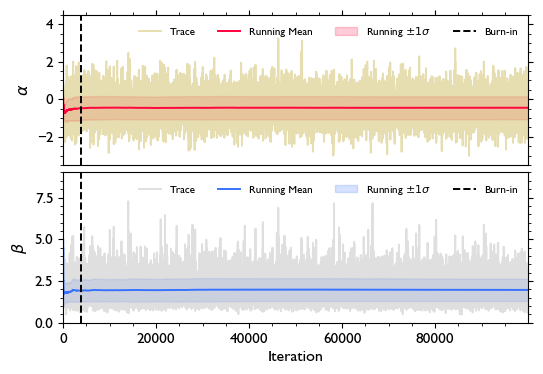

In [22]:
# === Trace Plots and Burn-in Period ==========================================

# Function to calculate summaries of the samples
def sample_summaries(samples):
    """
    Calculate the mean, median, standard deviation, 95% credible interval and
    68% credible interval of the samples.
    """
    # Mean
    mean = np.mean(samples, axis=0)
    # Median
    median = np.median(samples, axis=0)
    # Standard deviation
    std = np.std(samples, axis=0)
    # 95% credible interval
    ci95 = np.percentile(samples, [2.5, 97.5], axis=0)
    ci95_lower = ci95[0]
    ci95_upper = ci95[1]
    # 68% credible interval
    ci68 = np.percentile(samples, [16, 84], axis=0)
    ci68_lower = ci68[0]
    ci68_upper = ci68[1]
    return mean, median, std, ci95_lower, ci95_upper, ci68_lower, ci68_upper

# Calculate raw mean and standard deviation
mean_alpha_raw, _, std_alpha_raw, _, _, _, _ = sample_summaries(samples_alpha_raw)
mean_beta_raw, _, std_beta_raw, _, _, _, _ = sample_summaries(samples_beta_raw)

# Get running statistics with Welford's method
def welfords_method(samples):
    """
    Calculate the running mean and standard deviation of a set of samples using
    Welford's method.

    References
    ----------
    Welford, B.P. (1962) Note on a method for calculating corrected
    sums of squares and products. Technometrics, 4(3), 419-420.
    """
    # Calculate running mean
    running_mean = np.cumsum(samples)/(np.arange(len(samples)) + 1) 
    # Initialise variables
    n = 0
    mean = 0
    M2 = 0
    running_std = np.zeros(len(samples))
    # Loop through the samples
    for i, x in enumerate(samples):
        n += 1
        # Calculate mean and M2
        delta = x - mean
        mean += delta / n
        delta2 = x - mean
        M2 += delta * delta2
        # Calculate running standard deviation
        if n < 2:
            running_std[i] = float('nan')
        else:
            variance = M2 / (n - 1)
            running_std[i] = np.sqrt(variance)
    return running_mean, running_std

running_mean_alpha_raw, running_std_alpha_raw = welfords_method(samples_alpha_raw)
running_mean_beta_raw, running_std_beta_raw = welfords_method(samples_beta_raw)

# Define and compute burn-in period as the period where the running statistics are not stable
def get_burn_in(samples, running_mean, running_std, final_mean, final_std, threshold):
    for i in range(len(samples)):
        deviation_mean = np.abs((running_mean[i] - final_mean)/final_mean)
        deviation_std = np.abs((running_std[i] - final_std)/final_std)
        if deviation_mean < threshold and deviation_std < threshold:
            burnin = i
            break
    return burnin

threshold = 0.05
burn_in_alpha = get_burn_in(samples_alpha_raw, running_mean_alpha_raw, running_std_alpha_raw, mean_alpha_raw, std_alpha_raw, threshold)
burn_in_beta = get_burn_in(samples_beta_raw, running_mean_beta_raw, running_std_beta_raw, mean_beta_raw, std_beta_raw, threshold)
burn_in = max(burn_in_alpha, burn_in_beta)

print(f'Burn-in period for alpha: {burn_in_alpha}')
print(f'Burn-in period for beta: {burn_in_beta}')
print(f'Burn-in period: {burn_in}')

# Remove burn-in period
samples_alpha = samples_alpha_raw[burn_in:]
samples_beta = samples_beta_raw[burn_in:]

print(f'New chain length: {len(samples_alpha)}')

# Plot trace and running statistics
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05) 
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax0.plot(samples_alpha_raw, color=sd2022_gold, alpha = 0.5, label='Trace') 
ax0.plot(running_mean_alpha_raw, color=sd2022_red, alpha = 1, label='Running Mean')
ax0.fill_between(np.arange(n_steps), running_mean_alpha_raw - running_std_alpha_raw, running_mean_alpha_raw + running_std_alpha_raw, color=sd2022_red, alpha=0.2, label=r'Running $\pm 1\sigma$')
ax0.axvline(burn_in, color='black', linestyle='--', label='Burn-in')
ax0.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False)
ax0.legend(loc='upper right', ncol=4, fontsize=8)
ax0.set_ylabel(r'$\alpha$')
ax0.set_ylim(-3.5, 4.5)
ax1.plot(samples_beta_raw, color=sd2022_silver, alpha = 0.5, label='Trace')
ax1.plot(running_mean_beta_raw, color=sd2022_blue, alpha = 1, label='Running Mean')
ax1.fill_between(np.arange(n_steps), running_mean_beta_raw - running_std_beta_raw, running_mean_beta_raw + running_std_beta_raw, color=sd2022_blue, alpha=0.2, label=r'Running $\pm 1\sigma$')
ax1.axvline(burn_in, color='black', linestyle='--', label='Burn-in')
ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax1.legend(loc='upper right', ncol=4, fontsize=8)
ax1.set_ylabel(r'$\beta$')
ax1.set_xlabel('Iteration')
ax1.set_ylim(0, 9)
plt.show()

### Autocorrelation, Effective Sample Size and Thinning

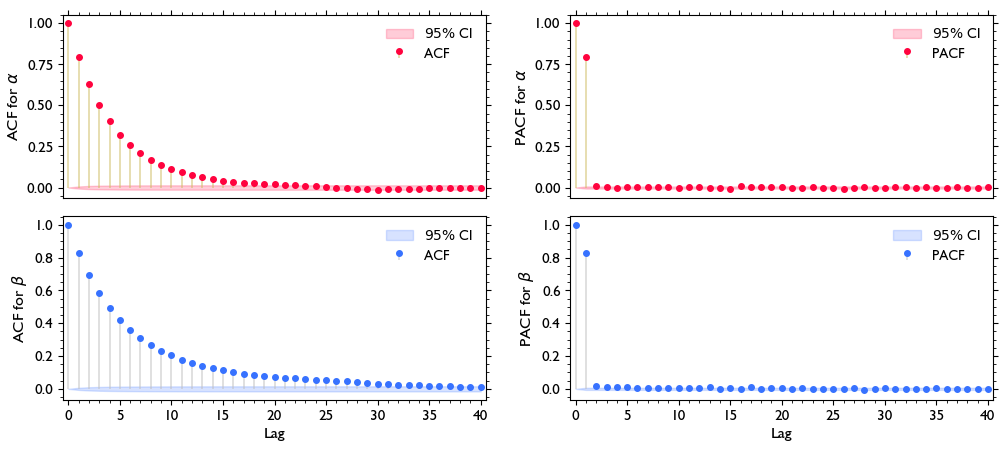

IAT for alpha: 8.939949579800516
IAT for beta: 12.884456224794235
IAT: 13
Number of iid samples: 7403
IAT for the second third of the chain: 12.621644183046488
IAT for the last third of the chain: 11.392654900806022


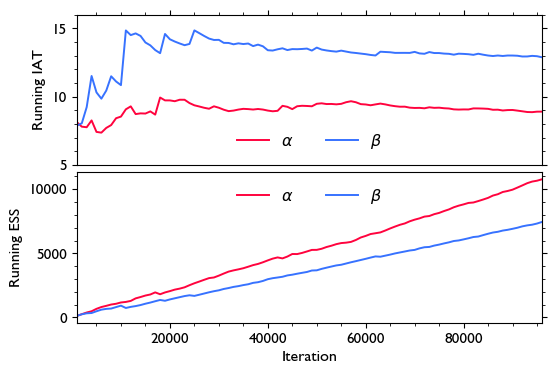

In [23]:
# === Autocorrelation and Thinning ============================================

# Get ACF and PACF values and confidence intervals (95%)
nlags = 40
ci = 0.05
acf_values_alpha, acf_cis_alpha = acf(samples_alpha, nlags=nlags, alpha=ci)
pacf_values_alpha, pacf_cis_alpha = pacf(samples_alpha, nlags=nlags, alpha=ci , method='ywm')
acf_values_beta, acf_cis_beta = acf(samples_beta, nlags=nlags, alpha=ci)
pacf_values_beta, pacf_cis_beta = pacf(samples_beta, nlags=nlags, alpha=ci, method='ywm')

# Plot trace and running statistics
def plot_stem_and_fill(ax, x_range, values, cis, label, color, color2, title):
    markerline, stemlines, baseline = ax.stem(x_range, values, linefmt=color2, markerfmt='o', basefmt=" ", label=title)
    plt.setp(markerline, 'markerfacecolor', color, 'markeredgecolor', color, markersize=4)
    plt.setp(stemlines, color=color2, alpha = 0.5)
    ax.fill_between(x_range, cis[:,0] - values, cis[:,1] - values, color=color, alpha=0.2, label=r'$95\%$ CI')
    ax.set_ylabel(label)
    ax.set_xlim(-0.5, len(x_range)-0.5)
    ax.legend(loc='upper right',fontsize=10)

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(2, 2, hspace=0.1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharey=ax0)
ax2 = fig.add_subplot(gs[2], sharex=ax1)
ax3 = fig.add_subplot(gs[3], sharey=ax2, sharex=ax1)

plot_stem_and_fill(ax0, range(len(acf_values_alpha)), acf_values_alpha, acf_cis_alpha, r'ACF for $\alpha$', sd2022_red, sd2022_gold, 'ACF')
plot_stem_and_fill(ax1, range(len(pacf_values_alpha)), pacf_values_alpha, pacf_cis_alpha, r'PACF for $\alpha$', sd2022_red, sd2022_gold, 'PACF')
plot_stem_and_fill(ax2, range(len(acf_values_beta)), acf_values_beta, acf_cis_beta, r'ACF for $\beta$', sd2022_blue, sd2022_silver, 'ACF')
plot_stem_and_fill(ax3, range(len(pacf_values_beta)), pacf_values_beta, pacf_cis_beta, r'PACF for $\beta$', sd2022_blue, sd2022_silver, 'PACF')

ax0.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False)
ax1.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False)
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax2.set_xlabel('Lag')
ax3.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax3.set_xlabel('Lag')
plt.show()

# Calculate auto-correlation time, number of iid samples and effective sample size
tau_alpha = emcee.autocorr.integrated_time(samples_alpha)[0]
tau_beta = emcee.autocorr.integrated_time(samples_beta)[0]
tau = int(np.ceil(max(tau_alpha, tau_beta)))

print(f'IAT for alpha: {tau_alpha}')
print(f'IAT for beta: {tau_beta}')
print(f'IAT: {tau}')

iid_alpha = samples_alpha[::int(tau)]
iid_beta = samples_beta[::int(tau)]

print(f'Number of iid samples: {len(iid_alpha)}')

# Compare the auto-correlation time at the middle and end of the chain
n = len(samples_alpha)
n_cut= int(n/3)
samples_alpha_1 = samples_alpha[n_cut:2*n_cut]
samples_alpha_2 = samples_alpha[2*n_cut:]
samples_beta_1 = samples_beta[n_cut:2*n_cut]
samples_beta_2 = samples_beta[2*n_cut:]
tau_alpha_1 = emcee.autocorr.integrated_time(samples_alpha_1)[0]
tau_alpha_2 = emcee.autocorr.integrated_time(samples_alpha_2)[0]
tau_beta_1 = emcee.autocorr.integrated_time(samples_beta_1)[0]
tau_beta_2 = emcee.autocorr.integrated_time(samples_beta_2)[0]
tau_1 = max(tau_alpha_1, tau_beta_1)
tau_2 = max(tau_alpha_2, tau_beta_2)

print(f'IAT for the second third of the chain: {tau_1}')
print(f'IAT for the last third of the chain: {tau_2}')

# Plot the running IAT and ESS
def running_iat_ess(samples, step=1000):
    """Calculates the running Integrated Autocorrelation Time and Effective Sample Size every 'step' samples."""
    # Initialise arrays
    n = len(samples)
    indices = range(0, n, step) 
    running_iat = np.zeros(len(indices))
    running_ess = np.zeros(len(indices))
    
    # Loop through the indices and calculate IAT and ESS with emcee at each index
    for j, i in enumerate(indices):
        try:
            running_iat[j] = emcee.autocorr.integrated_time(samples[:i+1], quiet=True)[0]
        except:
            running_iat[j] = np.nan  # if autocorr calculation fails
        running_ess[j] = i/(running_iat[j])

    return indices, running_iat, running_ess

indices_alpha, running_iat_alpha, running_ess_alpha = running_iat_ess(samples_alpha)
indices_beta, running_iat_beta, running_ess_beta = running_iat_ess(samples_beta)

fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05) 
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax0.plot(indices_alpha, running_iat_alpha, color=sd2022_red, label=r'$\alpha$') 
ax0.plot(indices_beta, running_iat_beta, color=sd2022_blue, label=r'$\beta$') 
ax0.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False)
ax0.set_ylim(5, 16)
ax0.set_ylabel('Running IAT')
ax0.legend(loc='lower center', ncol=2)
ax1.plot(indices_alpha, running_ess_alpha, color=sd2022_red, label=r'$\alpha$') 
ax1.plot(indices_beta, running_ess_beta, color=sd2022_blue, label=r'$\beta$') 
ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax1.set_ylabel('Running ESS')
ax1.set_xlabel('Iteration')
ax1.legend(loc='upper center', ncol=2)
plt.show()

### Analysis and Plots

In [24]:
# === Posterior samples summaries =============================================

# Calculate sample summaries
mean_alpha, median_alpha, std_alpha, ci95_lower_alpha, ci95_upper_alpha, ci68_lower_alpha, ci68_upper_alpha = sample_summaries(iid_alpha)
mean_beta, median_beta, std_beta, ci95_lower_beta, ci95_upper_beta, ci68_lower_beta, ci68_upper_beta = sample_summaries(iid_beta)
ci_alpha_plus = ci68_upper_alpha - median_alpha
ci_alpha_minus = median_alpha - ci68_lower_alpha
ci_beta_plus = ci68_upper_beta - median_beta
ci_beta_minus = median_beta - ci68_lower_beta

# Print summaries
print(f'Mean and std for alpha: {mean_alpha:.2f}+-{std_alpha:.2f}')
print(f'Mean and std for beta: {mean_beta:.2f}+-{std_beta:.2f}')
print(f'Median and 68% CI for alpha: {median_alpha:.2f}+{ci_alpha_plus:.2f}-{ci_alpha_minus:.2f}')
print(f'Median and 68% CI for beta: {median_beta:.2f}+{ci_beta_plus:.2f}-{ci_beta_minus:.2f}')
print(f'68% CI for alpha: [{ci68_lower_alpha:.2f},{ci68_upper_alpha:.2f}]')
print(f'68% CI for beta: [{ci68_lower_beta:.2f},{ci68_upper_beta:.2f}]')
print(f'95% CI for alpha: [{ci95_lower_alpha:.2f},{ci95_upper_alpha:.2f}]')
print(f'95% CI for beta: [{ci95_lower_beta:.2f},{ci95_upper_beta:.2f}]')

# Get running statistics with Welford's method for iid samples
running_mean_alpha, running_std_alpha = welfords_method(iid_alpha)
running_mean_beta, running_std_beta = welfords_method(iid_beta)


Mean and std for alpha: -0.45+-0.60
Mean and std for beta: 1.96+-0.67
Median and 68% CI for alpha: -0.47+0.60-0.54
Median and 68% CI for beta: 1.85+0.71-0.49
68% CI for alpha: [-1.02,0.13]
68% CI for beta: [1.36,2.56]
95% CI for alpha: [-1.57,0.76]
95% CI for beta: [0.99,3.60]


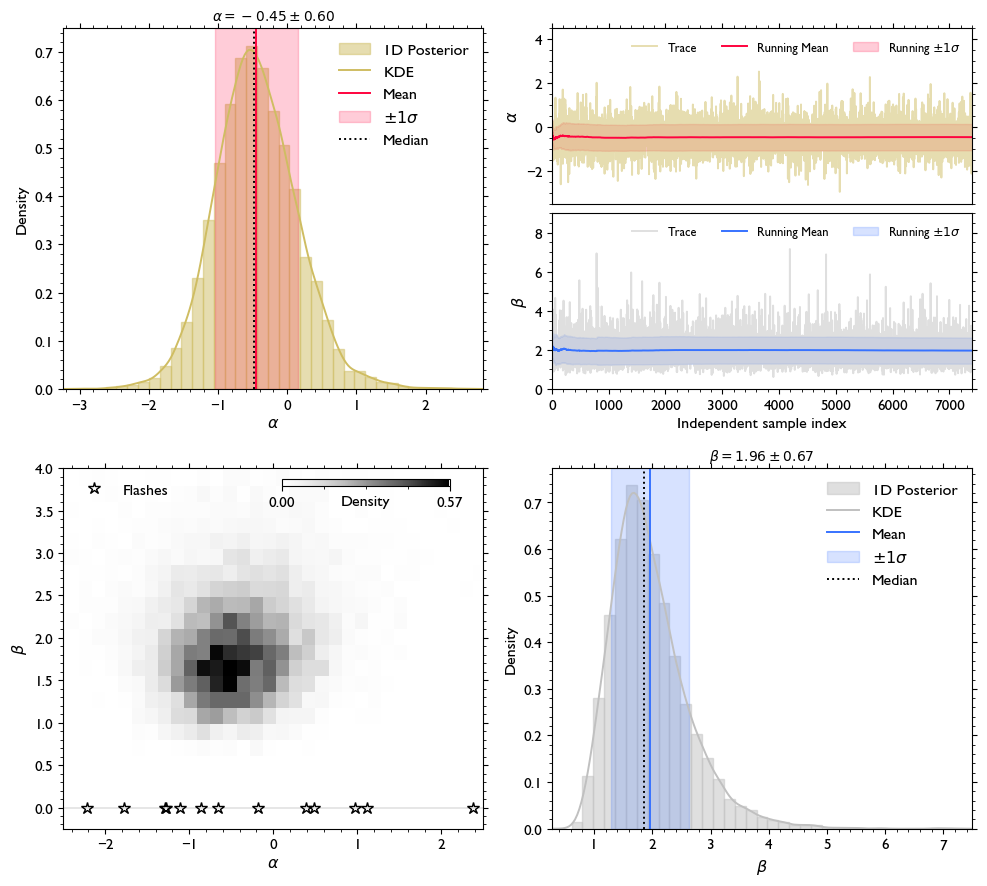

In [25]:
# === Plot the results ========================================================

# Figure and grid layout
fig = plt.figure(figsize=(10, 9))
gs = gridspec.GridSpec(2, 2, figure=fig)
gs_sub = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0, 1], hspace=0.05)
bins = 35

# Joint posterior on alpha and beta (2D histogram)
ax0 = fig.add_subplot(gs[1, 0])
cmap = plt.cm.Greys
hist2d = ax0.hist2d(iid_alpha, iid_beta, bins=bins, cmap=cmap,density=True)
ax0.set_xlabel(r'$\alpha$')
ax0.set_ylabel(r'$\beta$')
ax0.set_xlim(-2.5, 2.5)
ax0.set_ylim(-0.25, 4)
ax_bar = ax0.inset_axes([0.52, 0.95, 0.4, 0.02])
cbar = plt.colorbar(hist2d[3], cax=ax_bar, orientation='horizontal')
cbar.set_ticks([round(cbar.vmin,2), round(cbar.vmax,2)])
cbar.set_label('Density',labelpad=-10)
ax0.plot(x_data,np.zeros(len(x_data)), '*', color='none', markeredgecolor = 'black', markersize=9, label='Flashes')
ax0.axhline(0, color='black', linestyle='-', alpha=0.1)
legend = ax0.legend(loc='upper left')
ax0.set_facecolor(cmap(0.0)) 

# Marginalised posterior of beta (1D histogram)
ax1 = fig.add_subplot(gs[1, 1])
ax1.set_title(r'$\beta = {:.2f}\pm{:.2f}$'.format(mean_beta,std_beta), fontsize=10)
ax1.set_xlabel(r'$\beta$')
ax1.set_ylabel('Density')
ax1.hist(iid_beta, bins=bins, color=sd2022_silver, edgecolor= sd2022_silver, alpha = 0.5, density=True, label=r'1D Posterior')
sns.kdeplot(iid_beta, color=sd2022_silver, linestyle='-', label='KDE', ax=ax1)
ax1.axvline(mean_beta, color=sd2022_blue, linestyle='-', label='Mean')
ax1.set_ylim(ax1.get_ylim())
ax1.fill_between([mean_beta-std_beta, mean_beta+std_beta], ax1.get_ylim()[1], color=sd2022_blue, alpha=0.2, label=r'$\pm 1\sigma$')
ax1.axvline(median_beta, color = 'k', linestyle=':', label='Median')
ax1.legend()

# Marginalised posterior of alpha (1D histogram)
ax2 = fig.add_subplot(gs[0, 0])
ax2.set_title(r'$\alpha = {:.2f}\pm{:.2f}$'.format(mean_alpha,std_alpha), fontsize=10)
ax2.set_xlabel(r'$\alpha$')
ax2.set_ylabel('Density')
ax2.hist(iid_alpha, bins=bins, color=sd2022_gold, edgecolor= sd2022_gold, alpha = 0.5, density=True, label=r'1D Posterior')
sns.kdeplot(iid_alpha, color=sd2022_gold, linestyle='-', label='KDE', ax=ax2)
ax2.axvline(mean_alpha, color=sd2022_red, linestyle='-', label='Mean')
ax2.set_ylim(ax2.get_ylim())
ax2.fill_between([mean_alpha-std_alpha, mean_alpha+std_alpha], ax2.get_ylim()[1], color=sd2022_red, alpha=0.2, label=r'$\pm 1\sigma$')
ax2.axvline(median_alpha, color = 'k', linestyle=':', label='Median')
ax2.legend()

# Trace plot for alpha
ax3 = fig.add_subplot(gs_sub[0])
ax3.set_ylabel(r'$\alpha$')
ax3.plot(iid_alpha, color=sd2022_gold, alpha = 0.5, label = 'Trace')
ax3.plot(running_mean_alpha, color=sd2022_red, alpha = 1, label = 'Running Mean')
ax3.fill_between(np.arange(len(running_mean_alpha)), running_mean_alpha - running_std_alpha, running_mean_alpha + running_std_alpha, color=sd2022_red, alpha=0.2, label = r'Running $\pm 1\sigma$')
ax3.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False)
ax3.set_ylim(-3.5, 4.5)
ax3.legend(loc='upper right', fontsize=9, ncol=3)

# Trace plot for beta
ax4 = fig.add_subplot(gs_sub[1],sharex=ax3)
ax4.set_ylabel(r'$\beta$')
ax4.set_xlabel('Independent sample index')
ax4.plot(iid_beta, color=sd2022_silver, alpha = 0.5, label = 'Trace')
ax4.plot(running_mean_beta, color=sd2022_blue, alpha = 1, label = 'Running Mean')
ax4.fill_between(np.arange(len(running_mean_beta)), running_mean_beta - running_std_beta, running_mean_beta + running_std_beta, color=sd2022_blue, alpha=0.2, label = r'Running $\pm 1\sigma$')
ax4.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax4.set_ylim(0, 9)
ax4.legend(loc='upper right', fontsize=9, ncol=3)

plt.tight_layout()
plt.show()


## Extended Lighthouse Problem - Part (vii)

### Bayes' Theorem 

In [26]:
# === Define the likelihood function ==========================================

# Likelihood function for a set of flash intensities
def likelihood_lognorm(data, alpha, beta, i0):
    """
    Calculate the likelihood of observing a set of flashes with intensity data 
    given the parameters alpha, beta and i0.
    """
    # Calculate the expected intensity for each flash intensity
    distance_squared = beta**2 + (data[:, 0] - alpha)**2
    mu = np.log(i0/distance_squared)

    # Likelihoods for the intensities of single flashes
    likelihoods = lognorm.pdf(data[:, 1], 1, scale=np.exp(mu))

    # Likelihood for a set of flash intensities (product of likelihoods)
    likelihood = np.prod(likelihoods)

    return likelihood

# Log-likelihood function for a set of flash intensities
def log_likelihood_lognorm(data, alpha, beta, i0):
    """
    Calculate the log-likelihood of observing a set of flashes with intensity 
    data given the parameters alpha, beta and i0.
    """
    # Calculate the expected intensity for each flash intensity
    distance_squared = beta**2 + (data[:, 0] - alpha)**2
    mu = np.log(i0/distance_squared)

    # Log-likelihoods for the intensities of single flashes
    log_likelihoods = lognorm.logpdf(data[:, 1], 1, scale=np.exp(mu))

    # Log-likelihood for a set of flash intensities (product of log-likelihoods)
    log_likelihood = np.sum(log_likelihoods)

    return log_likelihood

## Log-likelihood function for combined location and intensity measurements
def log_likelihood_combined(data, alpha, beta, i0):
    """
    Calculate the log-likelihood of observing a set of flashes with locations 
    and intensities data given the parameters alpha, beta and i0.
    """
    # Log-likelihood for the locations
    log_likelihood_location = log_likelihood_cauchy(data[:, 0], alpha, beta)
    # Log-likelihood for the intensities
    log_likelihood_intensity = log_likelihood_lognorm(data, alpha, beta, i0)
    # Combined log-likelihood
    log_likelihood = log_likelihood_location + log_likelihood_intensity

    return log_likelihood

# === Define the prior functions ==============================================

# Log-uniform prior 
def prior_loguniform(param, range):
    """
    Calculate the prior probability of a parameter given a log-uniform prior.
    """
    return loguniform.pdf(param, range[0], range[1])

# Log-uniform prior in log
def log_prior_loguniform(param, range):
    """
    Calculate the prior probability of a parameter given a log-uniform prior 
    (in log).
    """
    return loguniform.logpdf(param, range[0], range[1], 0, 1)

# === Define the posterior function ===========================================

def log_posterior_extended(data, alpha, beta, i0, alpha_range, beta_range, i0_range):
    """
    Calculate the unnormalised log posterior probability of the parameters 
    alpha, beta and i0 given the observed data with Bayes theorem.
    """
    # Calculate the log likelihood of the observed data given alpha, beta and i0
    log_likelihood = log_likelihood_combined(data, alpha, beta, i0)
    
    # Calculate the log prior probabilities of alpha, beta and i0
    log_prior_alpha = log_prior_uniform(alpha, alpha_range)
    log_prior_beta = log_prior_uniform(beta, beta_range)
    log_prior_i0 = log_prior_loguniform(i0, i0_range)

    # Calculate the log posterior of alpha, beta and i0 given the data (Bayes rule)
    log_posterior = log_likelihood + log_prior_alpha + log_prior_beta + log_prior_i0

    return log_posterior

### Metropolis-Hastings MCMC Sampling

In [27]:
# === Implement the Metropolis-Hastings algorithm =============================

def metropolis_hastings_extended(data, initial_params, alpha_range, beta_range, i0_range, n_steps, step_size_ab, step_size_i0, seed = None):
    """
    Implement the Metropolis-Hastings algorithm to sample from the posterior
    distribution of the parameters alpha, beta and i0 given the observed data.

    Parameters
    ----------
    data : array
        The observed data.
    initial_params : array
        The initial values of the parameters alpha, beta and i0.
    alpha_range : array
        The range of the uniform prior for alpha.
    beta_range : array
        The range of the uniform prior for beta.
    i0_range : array
        The range of the log-uniform prior for i0.
    n_steps : int
        The number of steps to run the algorithm for.
    step_size_ab : float
        The standard deviation of the proposal distribution for alpha and beta.
    step_size_i0 : float
        The standard deviation of the proposal distribution for i0.
    seed : int
        The random seed to use.

    Returns
    -------
    chain : array
        The chain of samples from the posterior distribution.
    acceptance_rate : float
        The acceptance rate of the algorithm.
    """
    # Set random seed
    np.random.seed(seed)
    # Initialise the chain
    chain = np.zeros((n_steps, len(initial_params)))
    chain[0] = initial_params
    n_accepted = 0

    # Loop through the number of steps
    for i in range(n_steps-1):
        # Current state
        current_state = chain[i]
        # Proposal distribution
        cov_matrix = np.eye(3) 
        cov_matrix[0, 0] = step_size_ab**2
        cov_matrix[1, 1] = step_size_ab**2
        cov_matrix[2, 2] = step_size_i0**2
        proposal = multivariate_normal(mean=chain[i], cov=cov_matrix)
        # Proposed state
        proposed_state = proposal.rvs()
        # Log posterior of the current state
        log_posterior_current = log_posterior_extended(data, current_state[0], current_state[1], current_state[2], alpha_range, beta_range, i0_range)
        # Log posterior of the proposed state
        log_posterior_proposed = log_posterior_extended(data, proposed_state[0], proposed_state[1], proposed_state[2], alpha_range, beta_range, i0_range)
        # Acceptance ratio
        log_acceptance_ratio = log_posterior_proposed - log_posterior_current
        # Accept or reject the proposed state
        if np.log(np.random.uniform()) < log_acceptance_ratio:
            chain[i+1] = proposed_state
            n_accepted += 1
        else:
            chain[i+1] = current_state

    # Acceptance rate
    acceptance_rate = n_accepted / n_steps

    return chain, acceptance_rate

# === Run the Metropolis-Hastings algorithm ===================================

# Set the initial parameters
alpha_init = 0
beta_init = 4
i0_init = 6
initial_params = np.array([alpha_init, beta_init, i0_init])

# Set the ranges for the uniform priors
alpha_range = [-4, 4]
beta_range = [0, 8]
i0_range = [0.1, 12.1]

# Set the number of steps and step size (std of the proposal distribution)
n_steps = 100000
step_size_ab = 0.4 
step_size_i0 = 1.2

# Get the samples and acceptance rate
chain_ext, acceptance_rate_ext = metropolis_hastings_extended(data, initial_params, alpha_range, beta_range, i0_range, n_steps, step_size_ab, step_size_i0, seed=seed_football_number)
samples_alpha_ext_raw = chain_ext[:, 0]
samples_beta_ext_raw = chain_ext[:, 1]
samples_i0_ext_raw = chain_ext[:, 2]

print(f'Acceptance Ratio: {acceptance_rate_ext}')

Acceptance Ratio: 0.31227


### Trace Plots and Burn-in

Burn-in period for alpha: 23
Burn-in period for beta: 5969
Burn-in period for i0: 1434
Burn-in period: 5969
New chain length: 94031


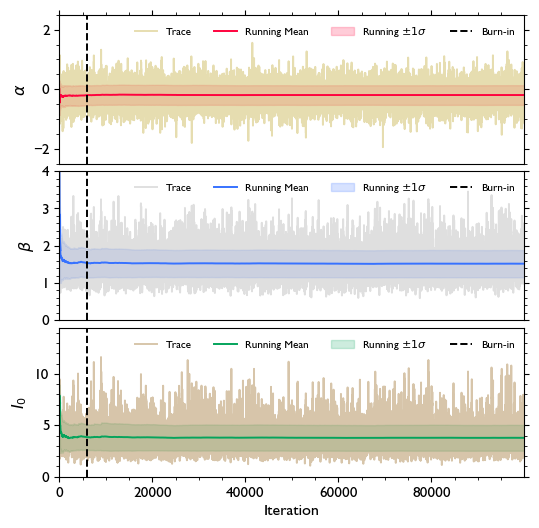

In [28]:
# === Trace Plots and Burn-in Period ==========================================

# Calculate raw mean and standard deviation
mean_alpha_ext_raw, _, std_alpha_ext_raw, _, _, _, _ = sample_summaries(samples_alpha_ext_raw)
mean_beta_ext_raw, _, std_beta_ext_raw, _, _, _, _ = sample_summaries(samples_beta_ext_raw)
mean_i0_ext_raw, _, std_i0_ext_raw, _, _, _, _ = sample_summaries(samples_i0_ext_raw)

# Get running statistics with Welford's method
running_mean_alpha_ext_raw, running_std_alpha_ext_raw = welfords_method(samples_alpha_ext_raw)
running_mean_beta_ext_raw, running_std_beta_ext_raw = welfords_method(samples_beta_ext_raw)
running_mean_i0_ext_raw, running_std_i0_ext_raw = welfords_method(samples_i0_ext_raw)

# Compute burn-in period as the period where the running statistics are not stable
threshold = 0.05
burn_in_alpha_ext = get_burn_in(samples_alpha_ext_raw, running_mean_alpha_ext_raw, running_std_alpha_ext_raw, mean_alpha_ext_raw, std_alpha_ext_raw, threshold)
burn_in_beta_ext = get_burn_in(samples_beta_ext_raw, running_mean_beta_ext_raw, running_std_beta_ext_raw, mean_beta_ext_raw, std_beta_ext_raw, threshold)
burn_in_i0_ext = get_burn_in(samples_i0_ext_raw, running_mean_i0_ext_raw, running_std_i0_ext_raw, mean_i0_ext_raw, std_i0_ext_raw, threshold)
burn_in_ext = max(burn_in_alpha_ext, burn_in_beta_ext, burn_in_i0_ext)

print(f'Burn-in period for alpha: {burn_in_alpha_ext}')
print(f'Burn-in period for beta: {burn_in_beta_ext}')
print(f'Burn-in period for i0: {burn_in_i0_ext}')
print(f'Burn-in period: {burn_in_ext}')

# Remove burn-in period
samples_alpha_ext = samples_alpha_ext_raw[burn_in_ext:]
samples_beta_ext = samples_beta_ext_raw[burn_in_ext:]
samples_i0_ext = samples_i0_ext_raw[burn_in_ext:]

print(f'New chain length: {len(samples_alpha_ext)}')

# Plot trace and running statistics
fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.05)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax2 = fig.add_subplot(gs[2], sharex=ax0)
ax0.plot(samples_alpha_ext_raw, color=sd2022_gold, alpha = 0.5, label='Trace') 
ax0.plot(running_mean_alpha_ext_raw, color=sd2022_red, alpha = 1, label='Running Mean')
ax0.fill_between(np.arange(n_steps), running_mean_alpha_ext_raw - running_std_alpha_ext_raw, running_mean_alpha_ext_raw + running_std_alpha_ext_raw, color=sd2022_red, alpha=0.2, label=r'Running $\pm 1\sigma$')
ax0.axvline(burn_in_ext, color='black', linestyle='--', label='Burn-in')
ax0.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False)
ax0.legend(loc='upper right', ncol=4, fontsize=8)
ax0.set_ylabel(r'$\alpha$')
ax0.set_ylim(-2.5, 2.5)
ax1.plot(samples_beta_ext_raw, color=sd2022_silver, alpha = 0.5, label='Trace')
ax1.plot(running_mean_beta_ext_raw, color=sd2022_blue, alpha = 1, label='Running Mean')
ax1.fill_between(np.arange(n_steps), running_mean_beta_ext_raw - running_std_beta_ext_raw, running_mean_beta_ext_raw + running_std_beta_ext_raw, color=sd2022_blue, alpha=0.2, label=r'Running $\pm 1\sigma$')
ax1.axvline(burn_in_ext, color='black', linestyle='--', label='Burn-in')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.legend(loc='upper right', ncol=4, fontsize=8)
ax1.set_ylabel(r'$\beta$')
ax1.set_ylim(0, 4)
ax2.plot(samples_i0_ext_raw, color=sd2022_bronze, alpha = 0.5, label='Trace')
ax2.plot(running_mean_i0_ext_raw, color=sd2022_green, alpha = 1, label='Running Mean')
ax2.fill_between(np.arange(n_steps), running_mean_i0_ext_raw - running_std_i0_ext_raw, running_mean_i0_ext_raw + running_std_i0_ext_raw, color=sd2022_green, alpha=0.2, label=r'Running $\pm 1\sigma$')
ax2.axvline(burn_in_ext, color='black', linestyle='--', label='Burn-in')
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax2.legend(loc='upper right', ncol=4, fontsize=8)
ax2.set_ylabel(r'$I_0$')
ax2.set_xlabel('Iteration')
ax2.set_ylim(0, 14.5)
plt.show()

### Autocorrelation, Effective Sample Size and Thinning

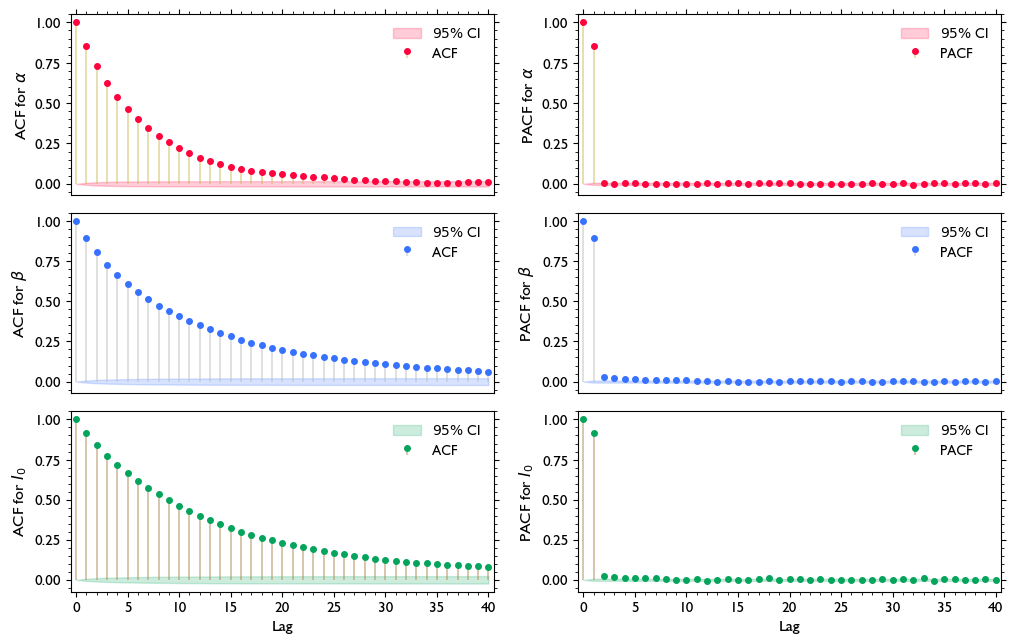

IAT for alpha: 14.2676758429538
IAT for beta: 25.897409795712704
IAT for i0: 29.540002813827282
IAT: 30
Number of iid samples: 3135
IAT for the middle third of the chain: 31.179856080026347
IAT for the last third of the chain: 29.26382281744222


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [36.47840259]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [30.50402493]


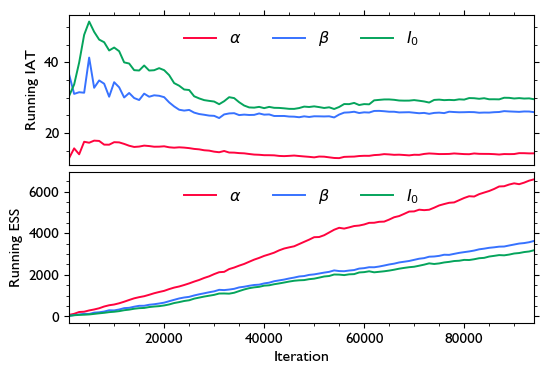

In [29]:
# === Autocorrelation and Thinning ============================================

# Get ACF and PACF values and confidence intervals (95%)
nlags = 40
ci = 0.05
acf_values_alpha_ext, acf_cis_alpha_ext = acf(samples_alpha_ext, nlags=nlags, alpha=ci)
pacf_values_alpha_ext, pacf_cis_alpha_ext = pacf(samples_alpha_ext, nlags=nlags, alpha=ci , method='ywm')
acf_values_beta_ext, acf_cis_beta_ext = acf(samples_beta_ext, nlags=nlags, alpha=ci)
pacf_values_beta_ext, pacf_cis_beta_ext = pacf(samples_beta_ext, nlags=nlags, alpha=ci, method='ywm')
acf_values_i0_ext, acf_cis_i0_ext = acf(samples_i0_ext, nlags=nlags, alpha=ci)
pacf_values_i0_ext, pacf_cis_i0_ext = pacf(samples_i0_ext, nlags=nlags, alpha=ci, method='ywm')

# Plot trace and running statistics
fig = plt.figure(figsize=(12, 7.5))
gs = gridspec.GridSpec(3,2, hspace=0.1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharey=ax0)
ax2 = fig.add_subplot(gs[2], sharex=ax1)
ax3 = fig.add_subplot(gs[3], sharey=ax2, sharex=ax1)
ax4 = fig.add_subplot(gs[4], sharex=ax1)
ax5 = fig.add_subplot(gs[5], sharey=ax4, sharex=ax1)

plot_stem_and_fill(ax0, range(len(acf_values_alpha_ext)), acf_values_alpha_ext, acf_cis_alpha_ext, r'ACF for $\alpha$', sd2022_red, sd2022_gold, 'ACF')
plot_stem_and_fill(ax1, range(len(pacf_values_alpha_ext)), pacf_values_alpha_ext, pacf_cis_alpha_ext, r'PACF for $\alpha$', sd2022_red, sd2022_gold, 'PACF')
plot_stem_and_fill(ax2, range(len(acf_values_beta_ext)), acf_values_beta_ext, acf_cis_beta_ext, r'ACF for $\beta$', sd2022_blue, sd2022_silver, 'ACF')
plot_stem_and_fill(ax3, range(len(pacf_values_beta_ext)), pacf_values_beta_ext, pacf_cis_beta_ext, r'PACF for $\beta$', sd2022_blue, sd2022_silver, 'PACF')
plot_stem_and_fill(ax4, range(len(acf_values_i0_ext)), acf_values_i0_ext, acf_cis_i0_ext, r'ACF for $I_0$', sd2022_green, sd2022_bronze, 'ACF')
plot_stem_and_fill(ax5, range(len(pacf_values_i0_ext)), pacf_values_i0_ext, pacf_cis_i0_ext, r'PACF for $I_0$', sd2022_green, sd2022_bronze, 'PACF')

ax0.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False)
ax1.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax4.set_xlabel('Lag')
ax5.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax5.set_xlabel('Lag')
plt.show()

# Calculate auto-correlation time, number of iid samples and effective sample size
tau_alpha_ext = emcee.autocorr.integrated_time(samples_alpha_ext)[0]
tau_beta_ext = emcee.autocorr.integrated_time(samples_beta_ext)[0]
tau_i0_ext = emcee.autocorr.integrated_time(samples_i0_ext)[0]
tau_ext = int(np.ceil(max(tau_alpha_ext, tau_beta_ext, tau_i0_ext)))

print(f'IAT for alpha: {tau_alpha_ext}')
print(f'IAT for beta: {tau_beta_ext}')
print(f'IAT for i0: {tau_i0_ext}')
print(f'IAT: {tau_ext}')

iid_alpha_ext = samples_alpha_ext[::int(tau_ext)]
iid_beta_ext = samples_beta_ext[::int(tau_ext)]
iid_i0_ext = samples_i0_ext[::int(tau_ext)]

print(f'Number of iid samples: {len(iid_alpha_ext)}')

# Compare the auto-correlation time at the middle and end of the chain
n_ext = len(samples_alpha_ext)
n_ext_cut = int(n_ext/3)
samples_alpha_1_ext = samples_alpha_ext[n_ext_cut:2*n_ext_cut]
samples_alpha_2_ext = samples_alpha_ext[2*n_ext_cut:]
samples_beta_1_ext = samples_beta_ext[n_ext_cut:2*n_ext_cut]
samples_beta_2_ext = samples_beta_ext[2*n_ext_cut:]
samples_i0_1_ext = samples_i0_ext[n_ext_cut:2*n_ext_cut]
samples_i0_2_ext = samples_i0_ext[2*n_ext_cut:]
tau_alpha_1_ext = emcee.autocorr.integrated_time(samples_alpha_1_ext)[0]
tau_alpha_2_ext = emcee.autocorr.integrated_time(samples_alpha_2_ext)[0]
tau_beta_1_ext = emcee.autocorr.integrated_time(samples_beta_1_ext)[0]
tau_beta_2_ext = emcee.autocorr.integrated_time(samples_beta_2_ext)[0]
tau_i0_1_ext = emcee.autocorr.integrated_time(samples_i0_1_ext)[0]
tau_i0_2_ext = emcee.autocorr.integrated_time(samples_i0_2_ext)[0]
tau_1_ext = max(tau_alpha_1_ext, tau_beta_1_ext, tau_i0_1_ext)
tau_2_ext = max(tau_alpha_2_ext, tau_beta_2_ext, tau_i0_2_ext)

print(f'IAT for the middle third of the chain: {tau_1_ext}')
print(f'IAT for the last third of the chain: {tau_2_ext}')

# Plot the running IAT and ESS
indices_alpha_ext, running_iat_alpha_ext, running_ess_alpha_ext = running_iat_ess(samples_alpha_ext)
indices_beta_ext, running_iat_beta_ext, running_ess_beta_ext = running_iat_ess(samples_beta_ext)
indices_i0_ext, running_iat_i0_ext, running_ess_i0_ext = running_iat_ess(samples_i0_ext)

fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05) 
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax0.plot(indices_alpha_ext, running_iat_alpha_ext, color=sd2022_red, label=r'$\alpha$') 
ax0.plot(indices_beta_ext, running_iat_beta_ext, color=sd2022_blue, label=r'$\beta$') 
ax0.plot(indices_i0_ext, running_iat_i0_ext, color=sd2022_green, label=r'$I_0$') 
ax0.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False)
ax0.set_ylabel('Running IAT')
ax0.legend(loc='upper center', ncol=3)
ax1.plot(indices_alpha_ext, running_ess_alpha_ext, color=sd2022_red, label=r'$\alpha$') 
ax1.plot(indices_beta_ext, running_ess_beta_ext, color=sd2022_blue, label=r'$\beta$') 
ax1.plot(indices_i0_ext, running_ess_i0_ext, color=sd2022_green, label=r'$I_0$') 
ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax1.set_ylabel('Running ESS')
ax1.set_xlabel('Iteration')
ax1.legend(loc='upper center', ncol=3)
plt.show()

### Analysis and Plots

In [30]:
# === Posterior samples summaries =============================================

# Calculate sample summaries
mean_alpha_ext, median_alpha_ext, std_alpha_ext, ci95_lower_alpha_ext, ci95_upper_alpha_ext, ci68_lower_alpha_ext, ci68_upper_alpha_ext = sample_summaries(iid_alpha_ext)
mean_beta_ext, median_beta_ext, std_beta_ext, ci95_lower_beta_ext, ci95_upper_beta_ext, ci68_lower_beta_ext, ci68_upper_beta_ext= sample_summaries(iid_beta_ext)
mean_i0_ext, median_i0_ext, std_i0_ext, ci95_lower_i0_ext, ci95_upper_i0_ext, ci68_lower_i0_ext, ci68_upper_i0_ext= sample_summaries(iid_i0_ext)
ci_alpha_plus_ext = ci68_upper_alpha_ext - median_alpha_ext
ci_alpha_minus_ext = median_alpha_ext - ci68_lower_alpha_ext
ci_beta_plus_ext = ci68_upper_beta_ext - median_beta_ext
ci_beta_minus_ext = median_beta_ext - ci68_lower_beta_ext
ci_i0_plus_ext = ci68_upper_i0_ext - median_i0_ext
ci_i0_minus_ext = median_i0_ext - ci68_lower_i0_ext

# Print summaries
print(f'Mean and std for alpha: {mean_alpha_ext:.2f}+-{std_alpha_ext:.2f}')
print(f'Mean and std for beta: {mean_beta_ext:.2f}+-{std_beta_ext:.2f}')
print(f'Mean and std for i0: {mean_i0_ext:.2f}+-{std_i0_ext:.2f}')
print(f'Median and 68% CI for alpha: {median_alpha_ext:.2f}+{ci_alpha_plus_ext:.2f}-{ci_alpha_minus_ext:.2f}')
print(f'Median and 68% CI for beta: {median_beta_ext:.2f}+{ci_beta_plus_ext:.2f}-{ci_beta_minus_ext:.2f}')
print(f'Median and 68% CI for i0: {median_i0_ext:.2f}+{ci_i0_plus_ext:.2f}-{ci_i0_minus_ext:.2f}')
print(f'68% CI for alpha: [{ci68_lower_alpha_ext:.2f},{ci68_upper_alpha_ext:.2f}]')
print(f'68% CI for beta: [{ci68_lower_beta_ext:.2f},{ci68_upper_beta_ext:.2f}]')
print(f'68% CI for i0: [{ci68_lower_i0_ext:.2f},{ci68_upper_i0_ext:.2f}]')
print(f'95% CI for alpha: [{ci95_lower_alpha_ext:.2f},{ci95_upper_alpha_ext:.2f}]')
print(f'95% CI for beta: [{ci95_lower_beta_ext:.2f},{ci95_upper_beta_ext:.2f}]')
print(f'95% CI for i0: [{ci95_lower_i0_ext:.2f},{ci95_upper_i0_ext:.2f}]')

# Get running statistics with Welford's method for iid samples
running_mean_alpha_ext, running_std_alpha_ext = welfords_method(iid_alpha_ext)
running_mean_beta_ext, running_std_beta_ext = welfords_method(iid_beta_ext)
running_mean_i0_ext, running_std_i0_ext = welfords_method(iid_i0_ext)


Mean and std for alpha: -0.19+-0.33
Mean and std for beta: 1.51+-0.36
Mean and std for i0: 3.80+-1.26
Median and 68% CI for alpha: -0.20+0.33-0.30
Median and 68% CI for beta: 1.47+0.39-0.30
Median and 68% CI for i0: 3.59+1.36-0.97
68% CI for alpha: [-0.50,0.13]
68% CI for beta: [1.17,1.86]
68% CI for i0: [2.62,4.95]
95% CI for alpha: [-0.86,0.47]
95% CI for beta: [0.93,2.32]
95% CI for i0: [1.98,6.79]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


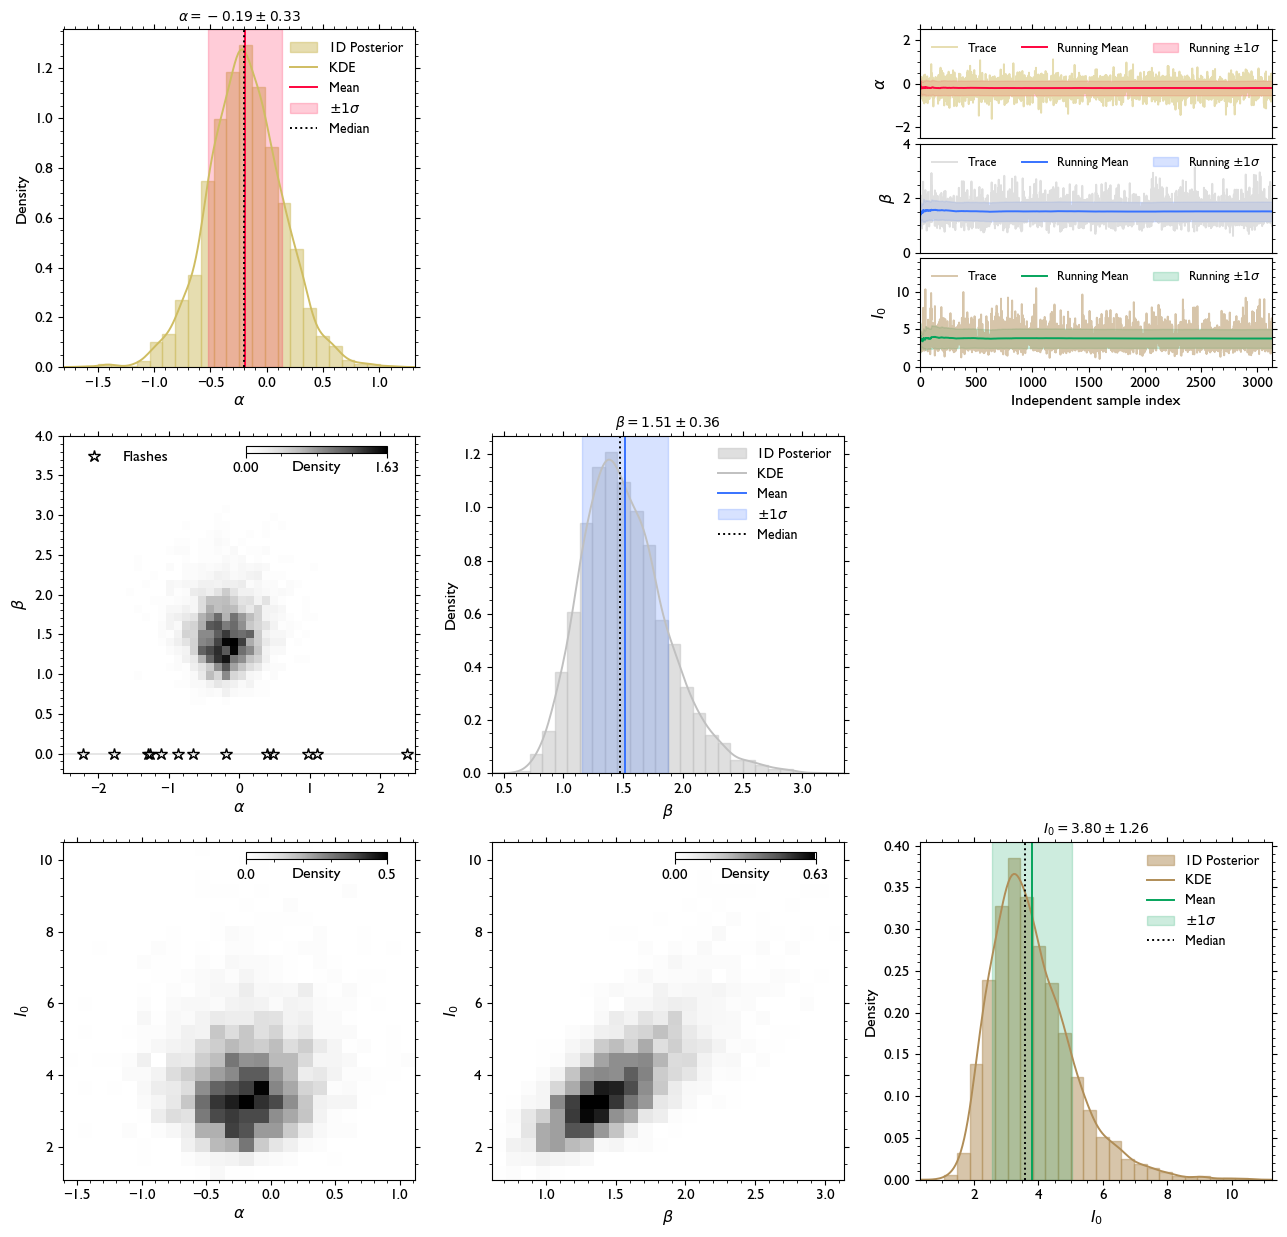

In [31]:
# === Plot the results ========================================================

# Figure and grid layout
fig = plt.figure(figsize=(13, 12.5))
gs = gridspec.GridSpec(3, 3, figure=fig)
gs_sub = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0, 2], hspace=0.05)
bins = 24

# Posterior on alpha and beta (2D histogram)
ax0 = fig.add_subplot(gs[1, 0])
cmap0 = plt.cm.Greys
hist2d0 = ax0.hist2d(iid_alpha_ext, iid_beta_ext, bins=bins, cmap=cmap0,density=True)
ax0.set_xlabel(r'$\alpha$')
ax0.set_ylabel(r'$\beta$')
ax0.set_xlim(-2.5, 2.5)
ax0.set_ylim(-0.25, 4)
ax_bar0 = ax0.inset_axes([0.52, 0.95, 0.4, 0.02])
cbar0 = plt.colorbar(hist2d0[3], cax=ax_bar0, orientation='horizontal')
cbar0.set_ticks([round(cbar0.vmin,2), round(cbar0.vmax,2)])
cbar0.set_label('Density',labelpad=-10)
ax0.plot(x_data,np.zeros(len(x_data)), '*', color='none', markeredgecolor = 'black', markersize=9, label='Flashes')
ax0.axhline(0, color='black', linestyle='-', alpha=0.1)
legend = ax0.legend(loc='upper left')
ax0.set_facecolor(cmap0(0.0)) 

# Posterior on alpha and i0 (2D histogram)
ax1 = fig.add_subplot(gs[2, 0])
cmap1 = plt.cm.Greys
hist2d1 = ax1.hist2d(iid_alpha_ext, iid_i0_ext, bins=bins, cmap=cmap1,density=True)
ax1.set_xlabel(r'$\alpha$')
ax1.set_ylabel(r'$I_0$')
ax_bar1 = ax1.inset_axes([0.52, 0.95, 0.4, 0.02])
cbar1 = plt.colorbar(hist2d1[3], cax=ax_bar1, orientation='horizontal')
cbar1.set_ticks([round(cbar1.vmin,2), round(cbar1.vmax,2)])
cbar1.set_label('Density',labelpad=-10)
legend = ax1.legend(loc='upper left')
ax1.set_facecolor(cmap1(0.0)) 

# Posterior on beta and i0 (2D histogram)
ax2 = fig.add_subplot(gs[2, 1])
cmap2 = plt.cm.Greys
hist2d2 = ax2.hist2d(iid_beta_ext, iid_i0_ext, bins=bins, cmap=cmap2, density=True)
ax2.set_xlabel(r'$\beta$')
ax2.set_ylabel(r'$I_0$')
ax_bar2 = ax2.inset_axes([0.52, 0.95, 0.4, 0.02])
cbar2 = plt.colorbar(hist2d2[3], cax=ax_bar2, orientation='horizontal')
cbar2.set_ticks([round(cbar2.vmin,2), round(cbar2.vmax,2)])
cbar2.set_label('Density',labelpad=-10)
legend = ax2.legend(loc='upper left')
ax2.set_facecolor(cmap2(0.0)) 

# Marginalised posterior of alpha (1D histogram)
ax3 = fig.add_subplot(gs[0, 0])
ax3.set_title(r'$\alpha = {:.2f}\pm{:.2f}$'.format(mean_alpha_ext,std_alpha_ext), fontsize=10)
ax3.set_xlabel(r'$\alpha$')
ax3.set_ylabel('Density')
ax3.hist(iid_alpha_ext, bins=bins, color=sd2022_gold, edgecolor= sd2022_gold, alpha = 0.5, density=True, label=r'1D Posterior')
sns.kdeplot(iid_alpha_ext, color=sd2022_gold, linestyle='-', label='KDE', ax=ax3)
ax3.axvline(mean_alpha_ext, color=sd2022_red, linestyle='-', label='Mean')
ax3.set_ylim(ax3.get_ylim())
ax3.fill_between([mean_alpha_ext-std_alpha_ext, mean_alpha_ext+std_alpha_ext], ax3.get_ylim()[1], color=sd2022_red, alpha=0.2, label=r'$\pm 1\sigma$')
ax3.axvline(median_alpha_ext, color = 'k', linestyle=':', label='Median')
ax3.legend(loc='upper right', fontsize=10)

# Marginalised posterior of beta (1D histogram)
ax4 = fig.add_subplot(gs[1, 1])
ax4.set_title(r'$\beta = {:.2f}\pm{:.2f}$'.format(mean_beta_ext,std_beta_ext), fontsize=10)
ax4.set_xlabel(r'$\beta$')
ax4.set_ylabel('Density')
ax4.hist(iid_beta_ext, bins=bins, color=sd2022_silver, edgecolor= sd2022_silver, alpha = 0.5, density=True, label=r'1D Posterior')
sns.kdeplot(iid_beta_ext, color=sd2022_silver, linestyle='-', label='KDE', ax=ax4) 
ax4.axvline(mean_beta_ext, color=sd2022_blue, linestyle='-', label='Mean')
ax4.set_ylim(ax4.get_ylim())
ax4.fill_between([mean_beta_ext-std_beta_ext, mean_beta_ext+std_beta_ext], ax4.get_ylim()[1], color=sd2022_blue, alpha=0.2, label=r'$\pm 1\sigma$')
ax4.axvline(median_beta_ext, color = 'k', linestyle=':', label='Median')
ax4.legend(loc='upper right', fontsize=10)

# Marginalised posterior of i0 (1D histogram)
ax5 = fig.add_subplot(gs[2, 2])
ax5.set_title(r'$I_0 = {:.2f}\pm{:.2f}$'.format(mean_i0_ext,std_i0_ext), fontsize=10)
ax5.set_xlabel(r'$I_0$')
ax5.set_ylabel('Density')
ax5.hist(iid_i0_ext, bins=bins, color=sd2022_bronze, edgecolor= sd2022_bronze, alpha = 0.5, density=True, label=r'1D Posterior')
sns.kdeplot(iid_i0_ext, color=sd2022_bronze, linestyle='-', label='KDE', ax=ax5)
ax5.axvline(mean_i0_ext, color=sd2022_green, linestyle='-', label='Mean')
ax5.set_ylim(ax5.get_ylim())
ax5.fill_between([mean_i0_ext-std_i0_ext, mean_i0_ext+std_i0_ext], ax5.get_ylim()[1], color=sd2022_green, alpha=0.2, label=r'$\pm 1\sigma$')
ax5.axvline(median_i0_ext, color = 'k', linestyle=':', label='Median')
ax5.legend(loc='upper right', fontsize=10)

# Trace plot for alpha
ax6 = fig.add_subplot(gs_sub[0])
ax6.set_ylabel(r'$\alpha$')
ax6.plot(iid_alpha_ext, color=sd2022_gold, alpha = 0.5, label = 'Trace')
ax6.plot(running_mean_alpha_ext, color=sd2022_red, alpha = 1, label = 'Running Mean')
ax6.fill_between(np.arange(len(running_mean_alpha_ext)), running_mean_alpha_ext - running_std_alpha_ext, running_mean_alpha_ext + running_std_alpha_ext, color=sd2022_red, alpha=0.2, label = r'Running $\pm 1\sigma$')
ax6.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False)
ax6.set_ylim(-2.5, 2.5)
ax6.legend(loc='upper right', fontsize=9, ncol=3)

# Trace plot for beta
ax7 = fig.add_subplot(gs_sub[1],sharex=ax6)
ax7.set_ylabel(r'$\beta$')
ax7.plot(iid_beta_ext, color=sd2022_silver, alpha = 0.5, label = 'Trace')
ax7.plot(running_mean_beta_ext, color=sd2022_blue, alpha = 1, label = 'Running Mean')
ax7.fill_between(np.arange(len(running_mean_beta_ext)), running_mean_beta_ext - running_std_beta_ext, running_mean_beta_ext + running_std_beta_ext, color=sd2022_blue, alpha=0.2, label = r'Running $\pm 1\sigma$')
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.set_ylim(0, 4)
ax7.legend(loc='upper right', fontsize=9, ncol=3)

# Trace plot for i0
ax8 = fig.add_subplot(gs_sub[2],sharex=ax6)
ax8.set_ylabel(r'$I_0$')
ax8.plot(iid_i0_ext, color=sd2022_bronze, alpha = 0.5, label = 'Trace')
ax8.plot(running_mean_i0_ext, color=sd2022_green, alpha = 1, label = 'Running Mean')
ax8.fill_between(np.arange(len(running_mean_i0_ext)), running_mean_i0_ext - running_std_i0_ext, running_mean_i0_ext + running_std_i0_ext, color=sd2022_green, alpha=0.2, label = r'Running $\pm 1\sigma$')
ax8.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax8.set_xlabel('Independent sample index')
ax8.set_ylim(0, 14.5)
ax8.legend(loc='upper right', fontsize=9, ncol=3)

plt.tight_layout()
plt.show()

## Comparison of Inference Results

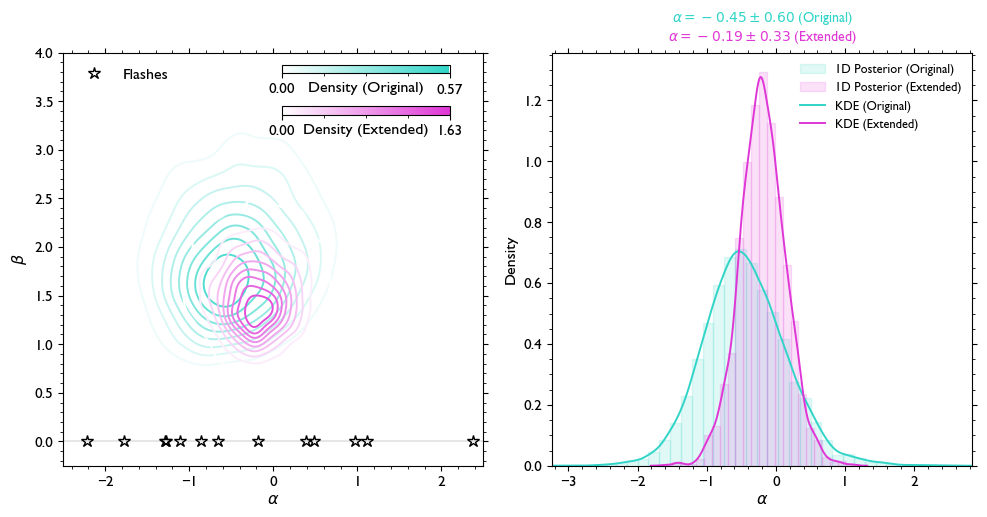

In [32]:
# === Plot the results ========================================================

# Figure and grid layout
fig = plt.figure(figsize=(10, 5.3))
gs = gridspec.GridSpec(1, 2, figure=fig)
bins1 = 35
bins2 = 24
cmap1 = cmap_turq
cmap2 = cmap_pink

# Joint posterior on alpha and beta (2D histogram)
ax0 = fig.add_subplot(gs[0])
hist2d = ax0.hist2d(iid_alpha, iid_beta, bins=bins1, cmap=cmap1, density=True)
hist2d_ext = ax0.hist2d(iid_alpha_ext, iid_beta_ext, bins=bins2, cmap=cmap2, density=True)
rect = patches.Rectangle((-2.5, 0), 5, 4, linewidth=1, edgecolor='white', facecolor='white')
ax0.add_patch(rect)
sns.kdeplot(x=iid_alpha, y=iid_beta, cmap=cmap1, ax = ax0)
sns.kdeplot(x=iid_alpha_ext, y=iid_beta_ext, cmap=cmap2, ax = ax0)
ax0.set_xlabel(r'$\alpha$')
ax0.set_ylabel(r'$\beta$')
ax0.set_xlim(-2.5, 2.5)
ax0.set_ylim(-0.25, 4)
ax_bar = ax0.inset_axes([0.52, 0.95, 0.4, 0.02])
ax_bar_ext = ax0.inset_axes([0.52, 0.85, 0.4, 0.02])
cbar = plt.colorbar(hist2d[3], cax=ax_bar, orientation='horizontal')
cbar.set_ticks([round(cbar.vmin,2), round(cbar.vmax,2)])
cbar.set_label('Density (Original)',labelpad=-10)
cbar2 = plt.colorbar(hist2d_ext[3], cax=ax_bar_ext, orientation='horizontal')
cbar2.set_ticks([round(cbar2.vmin,2), round(cbar2.vmax,2)])
cbar2.set_label('Density (Extended)',labelpad=-10)
ax0.plot(x_data,np.zeros(len(x_data)), '*', color='none', markeredgecolor = 'black', markersize=9, label='Flashes')
ax0.axhline(0, color='black', linestyle='-', alpha=0.1)
legend = ax0.legend(loc='upper left')
ax0.set_facecolor(cmap(0.0)) 

# Marginalised posterior of alpha (1D histogram)
ax1 = fig.add_subplot(gs[1])
ax1.set_xlabel(r'$\alpha$')
ax1.set_ylabel('Density')
ax1.hist(iid_alpha, bins=bins1, color=sd2022_turq, edgecolor = sd2022_turq, alpha = 0.15, density=True, label=r'1D Posterior (Original)')
ax1.hist(iid_alpha_ext, bins=bins2, color=sd2022_pink, edgecolor = sd2022_pink, alpha = 0.15, density=True, label=r'1D Posterior (Extended)')
sns.kdeplot(iid_alpha, color=sd2022_turq, linestyle='-', label='KDE (Original)', ax=ax1)
sns.kdeplot(iid_alpha_ext, color=sd2022_pink, linestyle='-', label='KDE (Extended)', ax=ax1)
ax1.set_ylim(ax1.get_ylim())
ax1.legend(fontsize=9)
title_text1 = r'$\alpha = {:.2f}\pm{:.2f}$ (Original)'.format(mean_alpha, std_alpha)
title_text2 = r'$\alpha = {:.2f}\pm{:.2f}$ (Extended)'.format(mean_alpha_ext, std_alpha_ext)
ax1.text(0.5, 1.075, title_text1, fontsize=10, color=sd2022_turq, ha='center', transform=ax1.transAxes)
ax1.text(0.5, 1.03, title_text2, fontsize=10, color=sd2022_pink, ha='center', transform=ax1.transAxes)

plt.tight_layout()
plt.show()